# Threshold bias (part II)

In [1]:
%pylab inline
# set the size of figures below
pylab.rcParams['figure.figsize'] = (15, 5)
from scipy.stats import norm

Populating the interactive namespace from numpy and matplotlib


In [2]:
show_plot=True
# this sets the threshold 
nu = 1.0
# probability density at the threshold
p_nu = norm.pdf(nu)
# density of galaxies is equal to the fraction of cells with density above the threshold 
mean = 1.0-norm.cdf(nu)
print('mean =',mean)

mean = 0.158655253931


### Simulate Fourier modes

In [3]:
# generate Fourier modes (see FourierModes notebook)
N=2**10
NF=int(N/2+1)
dx=1
# setup random number generator using seed
seed=123
gen = np.random.RandomState(seed)
k0=0.5
def power(k,k0):
    """Define here your favorite power spectrum. Mine is a Gaussian around k0."""
    P = np.zeros_like(k)
    # avoid log(k=0)
    nonzero = (k>0)
    P[nonzero] = np.exp(-np.log(k[nonzero]/k0)**2)
    return P

# get frequencies (wavenumbers)
k = np.fft.rfftfreq(N)*2*np.pi/dx
# get power evaluated at each k
P = power(k,k0)

# generate random Fourier modes
modes = np.empty(NF, dtype=complex)
modes[:].real = gen.normal(size=NF)
modes[:].imag = gen.normal(size=NF)
# normalize to desired power (and enforce real for i=0, i=NF-1)
modes[0] = modes[0].real * np.sqrt(P[0])
modes[-1] = modes[-1].real * np.sqrt(P[-1])
modes[1:-1] *= np.sqrt(0.5*P[1:-1])
delta = np.fft.irfft(modes) * np.sqrt(N/dx)
# enforce variance=1
var=np.var(delta)
print('var',np.var(delta))
delta /= np.sqrt(var)
print('mean',np.mean(delta))
print('var',np.var(delta))

var 0.356796131417
mean 3.90312782095e-18
var 1.0


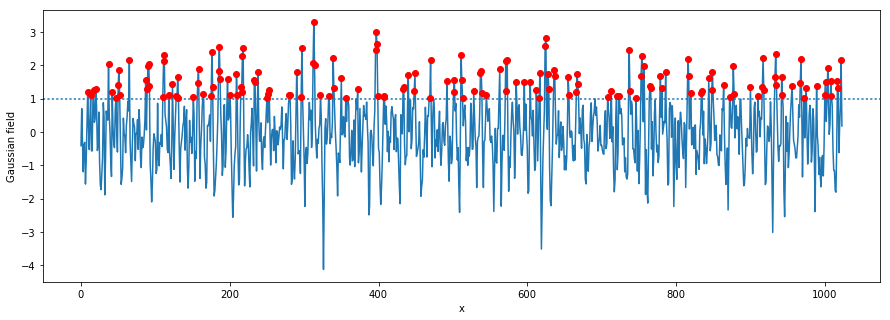

In [4]:
x=np.arange(N)
above = (delta>nu)
if show_plot:
    plt.plot(x,delta)
    plt.axhline(y=nu,ls=':') 
    plt.plot(x[above],delta[above],'ro')
    plt.xlabel('x')
    plt.ylabel('Gaussian field')

In [5]:
galaxy_density=np.zeros_like(delta)
galaxy_density[above]=1.0
mean_galaxy_density=np.mean(galaxy_density)
print('mean galaxy density',mean_galaxy_density)
delta_galaxy=galaxy_density/mean_galaxy_density-1.0
print('mean galaxy delta',np.mean(delta_galaxy))

mean galaxy density 0.15625
mean galaxy delta 3.46944695195e-17


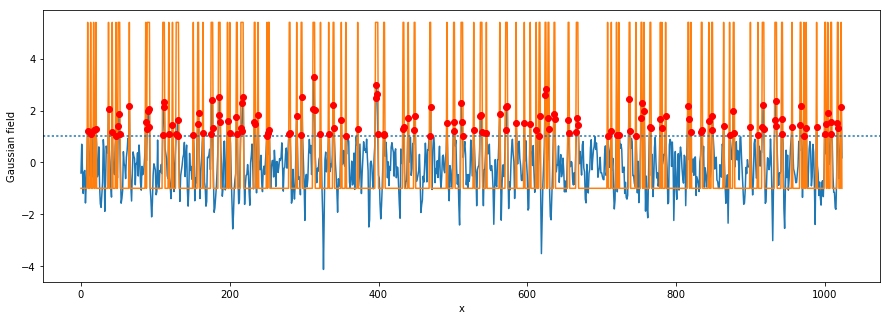

In [6]:
if show_plot:
    plt.plot(x,delta)
    plt.plot(x,delta_galaxy)
    plt.axhline(y=nu,ls=':')
    above = (delta>nu)
    plt.plot(x[above],delta[above],'ro')
    plt.xlabel('x')
    plt.ylabel('Gaussian field')

In [7]:
def get_modes(delta):
    """Given a delta field, return set of Fourier modes using FFT"""
    if N != len(delta):
        print('size mismatch',N,len(delta))
        raise SystemExit
    # inverse FFT to get (normalized) delta field
    modes = np.fft.rfft(delta) / np.sqrt(N/dx)
    new_delta = np.fft.irfft(modes) * np.sqrt(N/dx)
    return modes

In [8]:
k = np.fft.rfftfreq(N)*2*np.pi/dx
input_modes = get_modes(delta)
galaxy_modes = get_modes(delta_galaxy)

In [9]:
def binned_power(k,Pk,Nrebin):
    if NF != len(Pk):
        print('size mismatch',NF,len(Pk))
        raise SystemExit
    Nk=int(NF/Nrebin)
    #print('NF',NF)
    #print('Nk',Nk)
    binned_k = numpy.zeros(Nk)
    binned_Pk = numpy.zeros(Nk)
    binned_var_Pk = numpy.zeros(Nk)
    for i in range(0,NF):
        ibin=int(i/Nrebin)
        if ibin==Nk:
            continue
        binned_k[ibin] += k[i]
        binned_Pk[ibin] += Pk[i]
        binned_var_Pk[ibin] += Pk[i]*Pk[i] 
    for ibin in range(0,Nk):
        binned_k[ibin] /= Nrebin
        binned_Pk[ibin] /= Nrebin
        # variance in binned power
        binned_var_Pk[ibin] /= (Nrebin-1)
        binned_var_Pk[ibin] -= binned_Pk[ibin]*binned_Pk[ibin]
        # error in mean of binned power
        binned_var_Pk[ibin] /= Nrebin
    return binned_k, binned_Pk, binned_var_Pk

bias= 1.52513527616


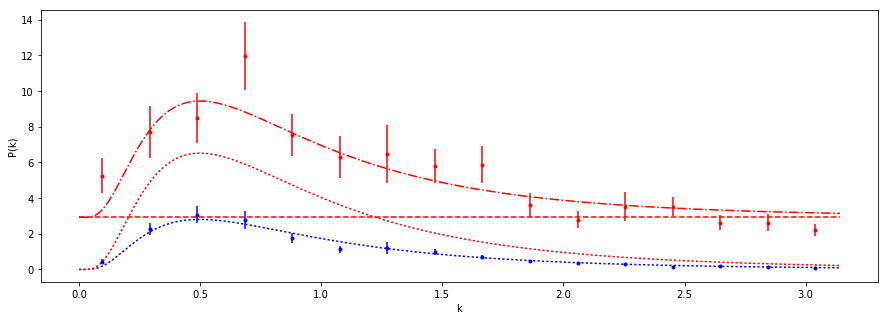

In [10]:
Nrebin=32
bin_k,bin_Pk,bin_var_Pk = binned_power(k,abs(input_modes)**2,Nrebin)
bin_gal_k, bin_gal_Pk,bin_var_gal_Pk = binned_power(k,abs(galaxy_modes)**2,Nrebin)
# bias to expect 
b = p_nu/mean
print('bias=',b)
# estimate shot noise
shot_noise=np.mean(bin_gal_Pk[-4:-1])
#print('shot noise =',shot_noise)
if show_plot:
    #plt.plot(k,Pk)
    #plt.plot(binned_k,binned_Pk)
    plt.errorbar(bin_k,bin_Pk,yerr=np.sqrt(bin_var_Pk), fmt='.',color='blue')
    plt.errorbar(bin_k,bin_gal_Pk,yerr=np.sqrt(bin_var_gal_Pk), fmt='.',color='red')
    plt.plot(k,power(k,k0)/var,color='blue',ls=':')
    plt.plot(k,b*b*power(k,k0)/var,color='red',ls=':') 
    plt.plot(k,b*b*power(k,k0)/var+shot_noise,color='red',ls='-.')     
    plt.plot(k,np.ones_like(k)*shot_noise,color='red',ls='--')     
    plt.xlabel('k')
    plt.ylabel('P(k)')
    #plt.legend()